Autor: Miguel Thomas

In [ ]:
import sys
assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from scipy.stats import binom
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

## Clase 1

In [ ]:
def load_dataset_url():
  tarbal_path = Path("datasets/housing.tgz")
  if not tarbal_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarbal_path)
    with tarfile.open(tarbal_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv("datasets/housing/housing.csv")

dataset = load_dataset_url()

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
dataset['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
IMAGES_PATH = Path() / "images" / "images_bar_housing"
IMAGES_PATH.mkdir(parents = True, exist_ok = True)

def save_fig(fig_id, tight_layout = True, fig_extention = "jpg", resolution = 300):
    path = IMAGES_PATH / f'{fig_id}.{fig_extention}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extention, dpi=resolution)

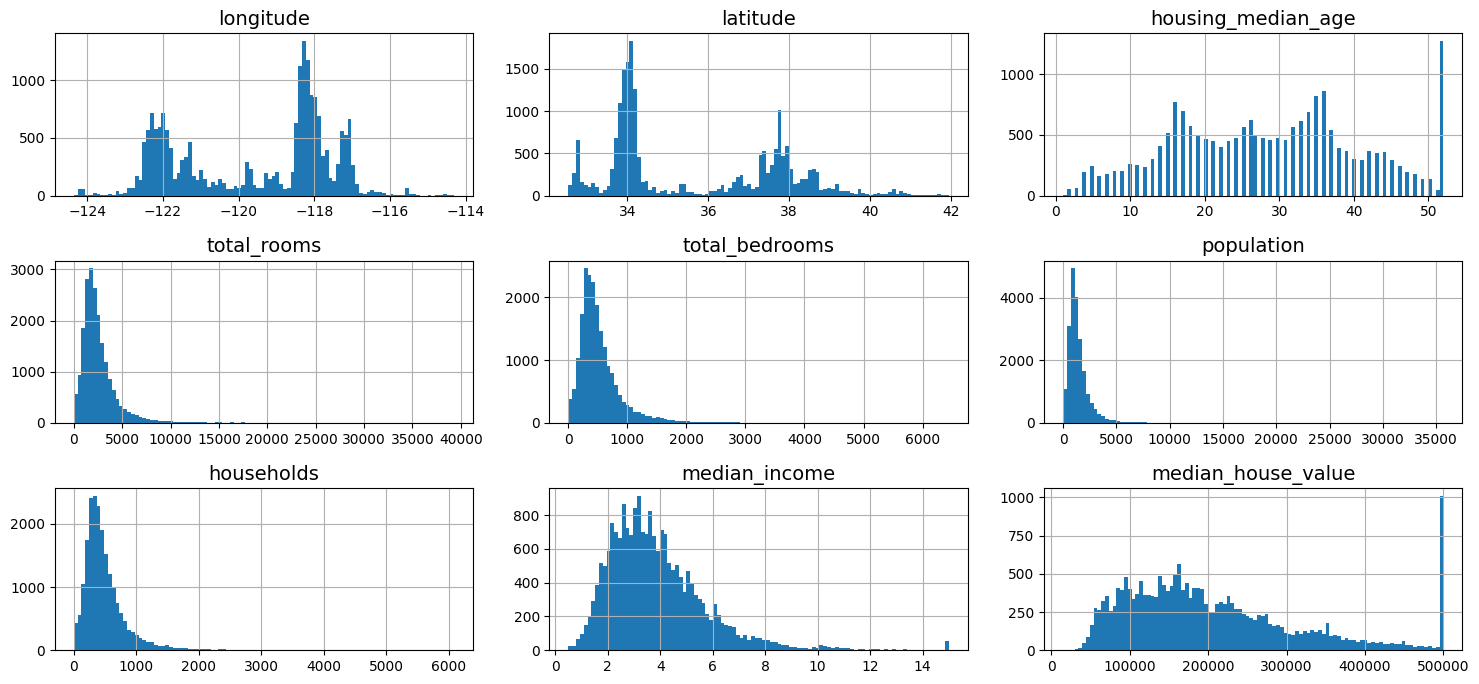

In [ ]:
plt.rc('font',size = 12)
plt.rc('axes', labelsize = 12, titlesize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

dataset.hist(bins = 100, figsize=(15,7))
save_fig("Grafica atributos Housing(Histograma)")
plt.show()

In [ ]:
def shuffle_and_split(data, test_radio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_radio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]


In [ ]:
train, test = shuffle_and_split(dataset, 0.3)

In [ ]:
print(len(train))
print(len(test))

14448
6192


In [ ]:
np.random.seed(42)

In [ ]:
from zlib import crc32

In [ ]:
def is_id_in_test(identifier, test_radio):
    return crc32(np.int64(identifier)) < test_radio * 2**32

In [ ]:
def  split_data_with_id_hash(data, test_radio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id: is_id_in_test(id, test_radio))
    return dataset.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
dataset_witd_id = dataset.reset_index()
train_set, test_set = split_data_with_id_hash(dataset_witd_id, 0.3, "index")

In [ ]:
dataset_witd_id["id"] = dataset['longitude']*1000 + dataset['latitude']
train_set, test_set = split_data_with_id_hash(dataset_witd_id, 0.3, "id")

In [ ]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


### Ejercicio

<p>
Muestre los resultados de las celdas 37 y 38 y concluya como se cambiaron los datos de entrenamiento y testeo
</p>

CONCLUSION:

En la Celda 37, el identificador se basa en el índice de fila original del DataFrame. Esto significa que la división es esencialmente aleatoria y no tiene en cuenta las características de los datos.

En la Celda 38, el identificador se basa en una combinación específica de características de los datos (en este caso, la ubicación geográfica). Esto podría llevar a una división que tenga en cuenta la distribución geográfica de los datos, potencialmente asegurando una mejor generalización del modelo si la ubicación geográfica es relevante para la tarea de modelado.

In [ ]:
#fig, ax = plt.subplots(figsize)

## CLase 2

In [ ]:
train_set, test_set = train_test_split(dataset, test_size = 0.3, random_state=42)

In [ ]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7061,-118.27,34.08,38.0,2265.0,801.0,2899.0,792.0,2.5521,157500.0,<1H OCEAN
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
17323,-118.09,34.71,5.0,5807.0,1182.0,2602.0,1007.0,2.4012,159400.0,INLAND
10056,-118.01,33.74,25.0,8110.0,1264.0,3613.0,1232.0,6.0609,264900.0,<1H OCEAN
15750,-117.19,32.77,14.0,3575.0,992.0,1645.0,839.0,2.4397,140600.0,NEAR OCEAN


In [ ]:
test_set['total_bedrooms'].isnull().sum()

75

In [ ]:
sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485-1)
proba_too_large = binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.9863220584176002


In [ ]:
np.random.seed(42)
samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis = 1)
((samples < 485) | (samples > 535)).mean()

0.1071

In [ ]:
dataset['income_category'] = pd.cut(dataset['median_income'],
                                    bins=[0.,1.5,3,4.5,6.,np.inf],
                                    labels = [1,2,3,4,5]
                                    )

In [ ]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


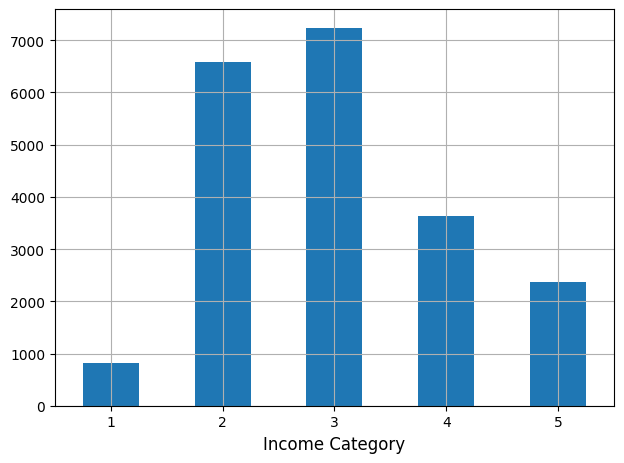

In [ ]:
dataset['income_category'].value_counts().sort_index().plot.bar(rot = 0, grid=True)
plt.xlabel('Income Category')
save_fig('figure_2')
plt.show()

In [ ]:
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)
stratified_split = []

for train_index, test_index in splitter.split(dataset, dataset['income_category']):
    stratified_train_set_n = dataset.iloc[train_index]
    stratified_test_set_n = dataset.iloc[test_index]
    stratified_split.append([stratified_train_set_n, stratified_test_set_n])


In [ ]:
strat_train_set, strat_test_set = stratified_split[0]

In [ ]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
6724,-122.11,37.98,11.0,4371.0,679.0,1790.0,660.0,6.1350,297300.0,NEAR BAY,5
4480,-117.10,33.17,12.0,2465.0,412.0,1226.0,428.0,5.4819,183800.0,<1H OCEAN,4
6108,-118.06,34.71,14.0,2606.0,514.0,1228.0,512.0,2.5764,150000.0,INLAND,2
16099,-122.28,38.31,52.0,58.0,18.0,48.0,22.0,1.7600,166700.0,NEAR BAY,2
8664,-118.51,34.22,36.0,1493.0,285.0,766.0,272.0,4.8646,213200.0,<1H OCEAN,4
...,...,...,...,...,...,...,...,...,...,...,...
13507,-118.09,33.90,37.0,1147.0,258.0,742.0,242.0,4.0461,153500.0,<1H OCEAN,3
14450,-122.22,38.11,43.0,1939.0,353.0,968.0,392.0,3.1848,112700.0,NEAR BAY,3
15432,-122.22,37.79,44.0,1487.0,314.0,961.0,272.0,3.5156,109500.0,NEAR BAY,3
4642,-119.87,36.79,7.0,1932.0,419.0,1014.0,389.0,3.0938,76700.0,INLAND,3


In [ ]:
strat_train_set, strat_test_set = train_test_split(dataset, test_size = 0.3, stratify = dataset['income_category'],random_state = 42)

In [ ]:
strat_test_set['income_category'].value_counts() / len(strat_test_set)

3    0.350614
2    0.318798
4    0.176357
5    0.114341
1    0.039890
Name: income_category, dtype: float64

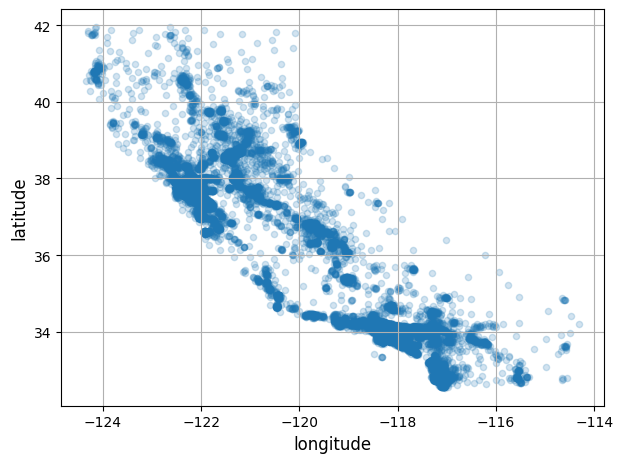

In [ ]:
dataset.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True, alpha=0.2)
save_fig('')
plt.show()

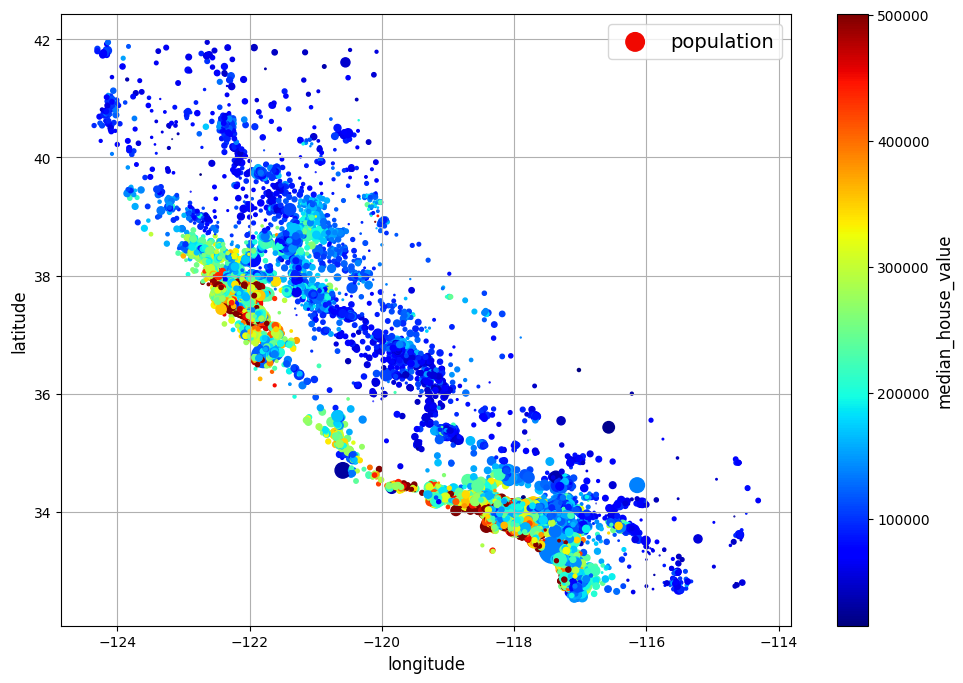

In [ ]:
dataset.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True,
             s =dataset['population']/100, label = 'population',
             c = 'median_house_value', cmap = 'jet', colorbar= True, figsize = (10,7))
save_fig('mapa de calor - population')
plt.show()

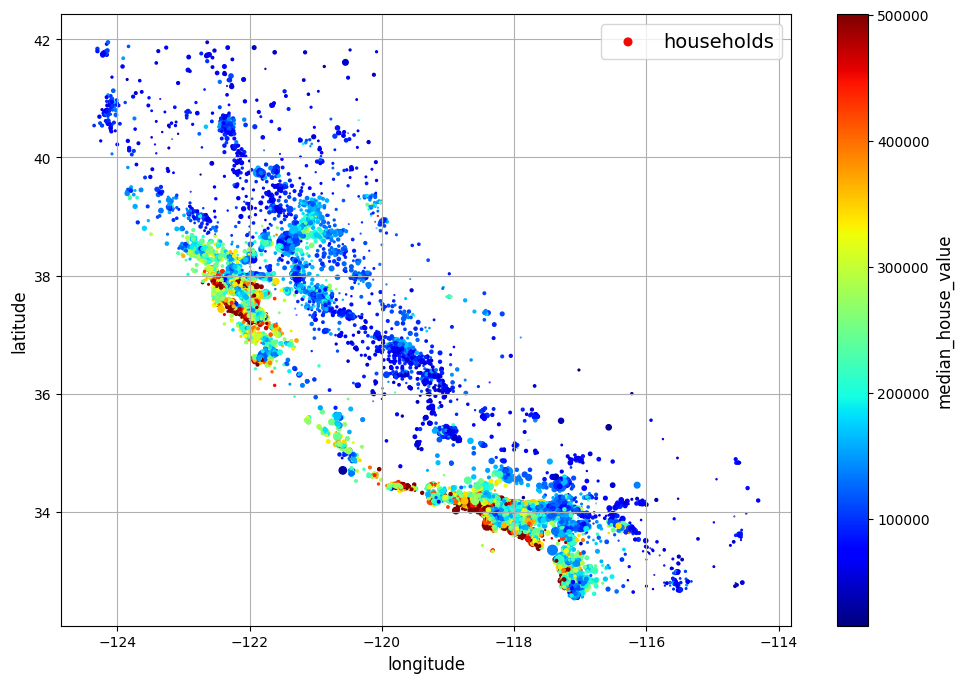

In [ ]:
dataset.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True,
             s =dataset['households']/100, label = 'households',
             c = 'median_house_value', cmap = 'jet', colorbar= True, figsize = (10,7))
save_fig('mapa de calor - households')
plt.show()

## Clase 3

### Buscando correlaciones

In [ ]:
corr_matrix = dataset.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [ ]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

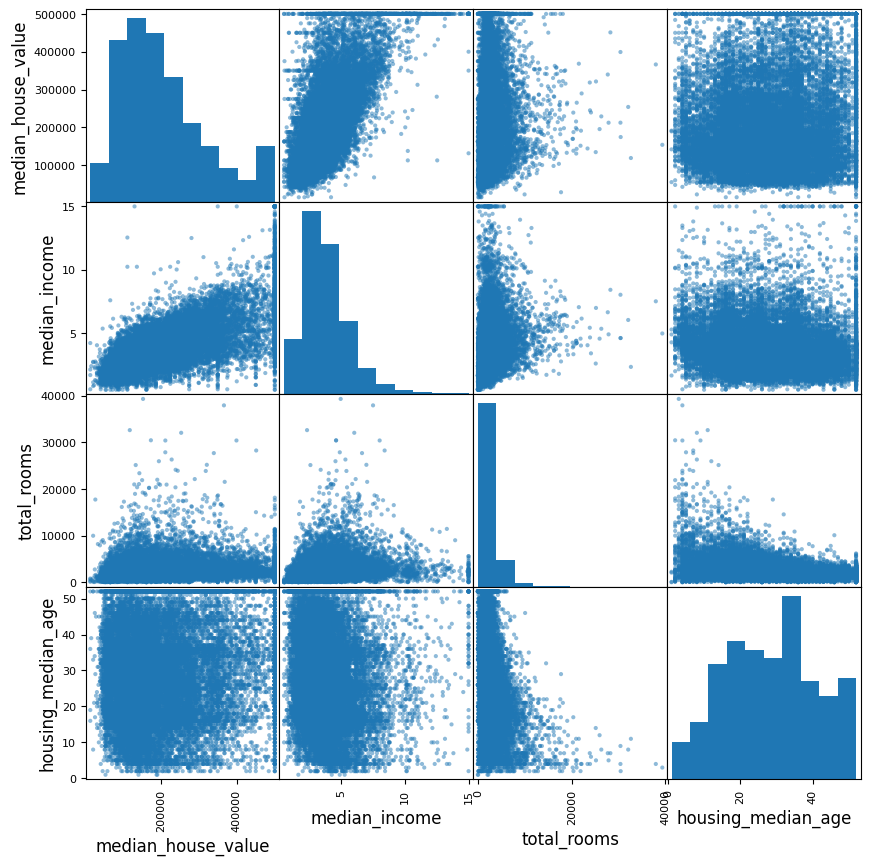

In [ ]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']

scatter_matrix(dataset[attributes], figsize=(10,10))
plt.show()

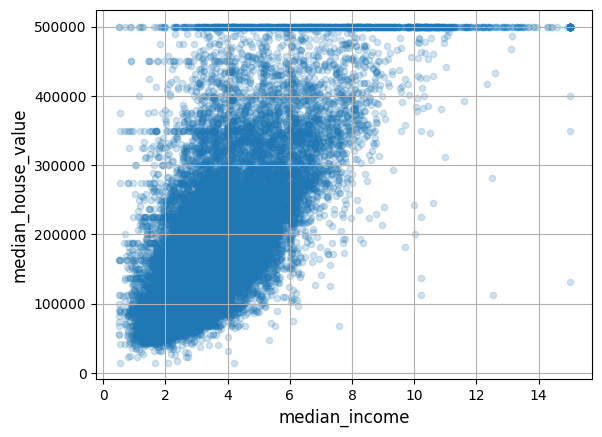

In [ ]:
dataset.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.2, grid=True)
plt.show()

In [ ]:
dataset['rooms_per_house'] = dataset['total_rooms'] / dataset['households']
dataset['rooms_per_house'].head()

0    6.984127
1    6.238137
2    8.288136
3    5.817352
4    6.281853
Name: rooms_per_house, dtype: float64

In [ ]:
dataset['bedrooms'] = dataset['total_bedrooms'] / dataset['total_rooms']
dataset['bedrooms'].head()

0    0.146591
1    0.155797
2    0.129516
3    0.184458
4    0.172096
Name: bedrooms, dtype: float64

In [ ]:
dataset['people_per_house'] = dataset['population'] / dataset['households']
dataset['people_per_house'].head()

0    2.555556
1    2.109842
2    2.802260
3    2.547945
4    2.181467
Name: people_per_house, dtype: float64

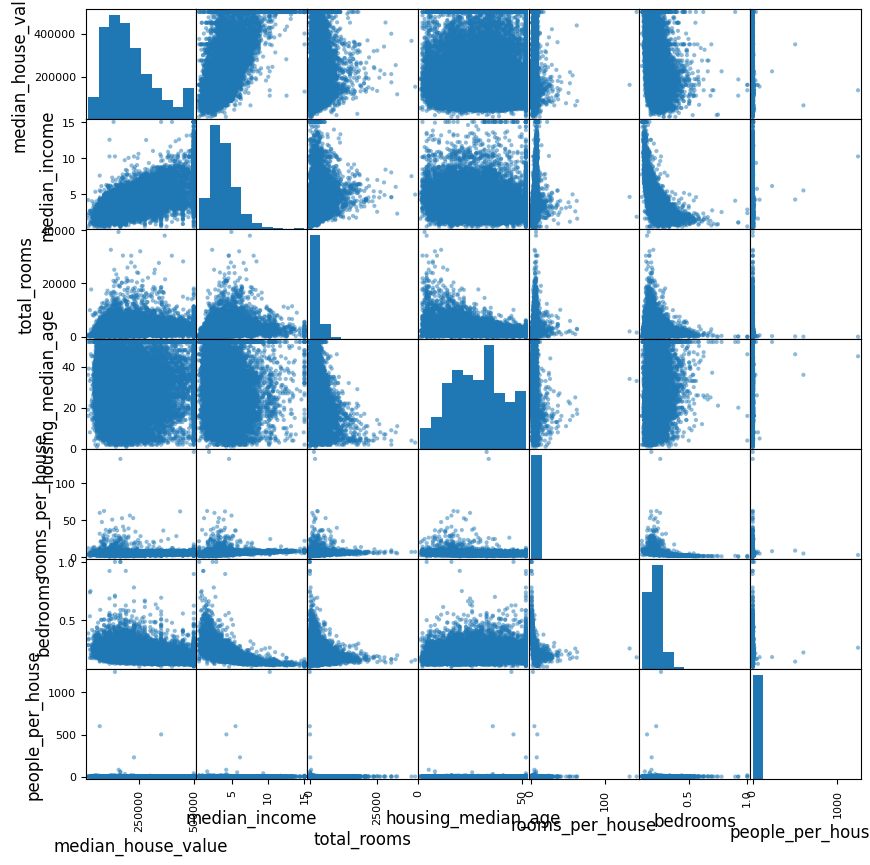

In [ ]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age',
              'rooms_per_house','bedrooms','people_per_house']

scatter_matrix(dataset[attributes], figsize=(10,10))
plt.show()

In [ ]:
corr_matrix = dataset.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms             -0.255880
Name: median_house_value, dtype: float64

#### ANALISIS:
A pesar de que la mejor relacion se da entre la variable; "median_income" y la variable objetivo; "median_house_value", se puede notar que hay valores atipicos que podrian romper el modelo al momento de entrenar. Por eso se crean nuevas caracteristicas que podrian llevar a un mejor entendimiento y entrenamiento del modelo.
Las caracteristicas nuevas son:
1. people_per_house: El numero de personas por casa para ver si existe una relacion entre el numero de personas y el valor de la casa
2. bedrooms: numero de baños por cada habitacion
3. rooms_per_house: numero de habitaciones por casa

Podemos notar que el unico que tiene una relacion positiva es el numero de habitaciones por casa, a pesar de esto, podemos ver en la grafica que no tiene el mejor modelo.

### Preprocesamiento de datos faltantes

"""
dataset.dropna(subset=['total_bedrooms'], inplace=True)

dataset.drop('total_bedrooms', axis=1)

median_data = dataset['total_bedrooms'].median()

dataset['total_bedroom'].fillna(media_data, inplace=True)

"""

In [ ]:
dt = strat_test_set.drop('median_house_value', axis=1)
dt_labels = strat_train_set['median_house_value'].copy()


In [ ]:
null_rows_idx = dt.isnull().any(axis=1)
dt.loc[null_rows_idx]
dt

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_category
17882,-118.13,34.13,39.0,2099.0,397.0,1500.0,380.0,4.8304,<1H OCEAN,4
17298,-122.51,37.76,40.0,2320.0,562.0,1499.0,521.0,3.2792,NEAR OCEAN,3
9641,-118.29,33.98,46.0,1118.0,300.0,786.0,254.0,1.4042,<1H OCEAN,1
3404,-118.09,33.77,26.0,5359.0,1508.0,1829.0,1393.0,1.7675,<1H OCEAN,2
8969,-122.00,37.30,28.0,5096.0,1011.0,2588.0,954.0,5.3570,<1H OCEAN,4
...,...,...,...,...,...,...,...,...,...,...
19000,-119.66,37.39,10.0,2106.0,410.0,1003.0,397.0,2.7813,INLAND,2
1656,-122.20,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175,NEAR BAY,5
7706,-118.87,35.65,33.0,1504.0,325.0,584.0,223.0,3.4792,INLAND,3
15022,-121.37,38.70,26.0,2230.0,410.0,1155.0,377.0,3.4911,INLAND,3


In [ ]:
datadropna = dt.copy()
datadropna.dropna(subset=["total_bedrooms"], inplace=True)
datadropna = datadropna.loc[null_rows_idx]
datadropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           0 non-null      float64 
 1   latitude            0 non-null      float64 
 2   housing_median_age  0 non-null      float64 
 3   total_rooms         0 non-null      float64 
 4   total_bedrooms      0 non-null      float64 
 5   population          0 non-null      float64 
 6   households          0 non-null      float64 
 7   median_income       0 non-null      float64 
 8   ocean_proximity     0 non-null      object  
 9   income_category     0 non-null      category
dtypes: category(1), float64(8), object(1)
memory usage: 212.0+ bytes


In [ ]:
datadrop = dt.copy()
datadrop.drop("total_bedrooms", axis=1, inplace=True)
datadrop = datadrop.loc[null_rows_idx]
datadrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 14730 to 3568
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           60 non-null     float64 
 1   latitude            60 non-null     float64 
 2   housing_median_age  60 non-null     float64 
 3   total_rooms         60 non-null     float64 
 4   population          60 non-null     float64 
 5   households          60 non-null     float64 
 6   median_income       60 non-null     float64 
 7   ocean_proximity     60 non-null     object  
 8   income_category     60 non-null     category
dtypes: category(1), float64(7), object(1)
memory usage: 4.5+ KB


In [ ]:
datafill = dt.copy()
median_data = datafill["total_bedrooms"].median()
datafill["total_bedrooms"].fillna(median_data, inplace=True)
datafill = datafill.loc[null_rows_idx]
datafill

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_category
14730,-117.65,33.60,15.0,5736.0,441.0,2529.0,762.0,6.4114,<1H OCEAN,5
16519,-117.86,34.01,16.0,4632.0,441.0,3038.0,727.0,5.1762,<1H OCEAN,4
19880,-118.23,33.94,36.0,1110.0,441.0,1417.0,302.0,2.3333,<1H OCEAN,2
16165,-121.33,38.02,31.0,1466.0,441.0,608.0,254.0,3.1827,INLAND,3
14615,-122.01,37.94,23.0,3741.0,441.0,1339.0,499.0,6.7061,NEAR BAY,5
2455,-122.28,37.78,29.0,5154.0,441.0,3741.0,1273.0,2.5762,NEAR BAY,2
4119,-117.20,33.24,12.0,4992.0,441.0,2106.0,801.0,6.2079,<1H OCEAN,5
12188,-121.02,37.48,26.0,467.0,441.0,244.0,83.0,4.1346,INLAND,3
19248,-122.50,37.75,45.0,1620.0,441.0,941.0,328.0,4.3859,NEAR OCEAN,3
14133,-121.90,37.28,26.0,3756.0,441.0,1408.0,535.0,5.6427,<1H OCEAN,4


### Conclusion:
1. datadropna (dropna): elimina las filas con valores faltantes en "total_bedrooms", lo cual puede reducir significativamente el tamaño del dataset si hay muchos valores faltantes, potencialmente perdiendo información valiosa en otras columnas.
2. datadrop (drop): elimina toda la columna "total_bedrooms", lo cual podría no ser ideal si la columna es importante para el análisis o modelado posterior.
3. datafill (fillna): rellena los valores faltantes con la mediana, lo cual es una estrategia común para mantener el tamaño del dataset y posiblemente preservar la distribución de los datos, aunque introduce un sesgo al asumir que los valores faltantes se distribuyen de manera similar a los observados.

RECUERDA COMPLETAR ESO

## Clase 4

### Imputacion de datos:



In [ ]:
imputer = SimpleImputer(strategy='median')
imputer

SimpleImputer(strategy='median')

In [ ]:
dataset_numerics = dt.select_dtypes(include=[np.number])
dataset_numerics

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17882,-118.13,34.13,39.0,2099.0,397.0,1500.0,380.0,4.8304
17298,-122.51,37.76,40.0,2320.0,562.0,1499.0,521.0,3.2792
9641,-118.29,33.98,46.0,1118.0,300.0,786.0,254.0,1.4042
3404,-118.09,33.77,26.0,5359.0,1508.0,1829.0,1393.0,1.7675
8969,-122.00,37.30,28.0,5096.0,1011.0,2588.0,954.0,5.3570
...,...,...,...,...,...,...,...,...
19000,-119.66,37.39,10.0,2106.0,410.0,1003.0,397.0,2.7813
1656,-122.20,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175
7706,-118.87,35.65,33.0,1504.0,325.0,584.0,223.0,3.4792
15022,-121.37,38.70,26.0,2230.0,410.0,1155.0,377.0,3.4911


In [ ]:
imputer.fit(dataset_numerics) #Esta entrenado

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.48   ,   34.25   ,   29.     , 2168.     ,  441.     ,
       1173.     ,  416.     ,    3.52965])

In [ ]:
dataset_numerics.median().values

array([-118.48   ,   34.25   ,   29.     , 2168.     ,  441.     ,
       1173.     ,  416.     ,    3.52965])

In [ ]:
X = imputer.transform(dataset_numerics)
X

array([[-1.1813e+02,  3.4130e+01,  3.9000e+01, ...,  1.5000e+03,
         3.8000e+02,  4.8304e+00],
       [-1.2251e+02,  3.7760e+01,  4.0000e+01, ...,  1.4990e+03,
         5.2100e+02,  3.2792e+00],
       [-1.1829e+02,  3.3980e+01,  4.6000e+01, ...,  7.8600e+02,
         2.5400e+02,  1.4042e+00],
       ...,
       [-1.1887e+02,  3.5650e+01,  3.3000e+01, ...,  5.8400e+02,
         2.2300e+02,  3.4792e+00],
       [-1.2137e+02,  3.8700e+01,  2.6000e+01, ...,  1.1550e+03,
         3.7700e+02,  3.4911e+00],
       [-1.1834e+02,  3.4030e+01,  4.7000e+01, ...,  1.3490e+03,
         5.0800e+02,  1.3444e+00]])

In [ ]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [ ]:
dataset_df = pd.DataFrame(X, columns=dataset_numerics.columns,
                          index=dataset_numerics.index)
dataset_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17882,-118.13,34.13,39.0,2099.0,397.0,1500.0,380.0,4.8304
17298,-122.51,37.76,40.0,2320.0,562.0,1499.0,521.0,3.2792
9641,-118.29,33.98,46.0,1118.0,300.0,786.0,254.0,1.4042
3404,-118.09,33.77,26.0,5359.0,1508.0,1829.0,1393.0,1.7675
8969,-122.00,37.30,28.0,5096.0,1011.0,2588.0,954.0,5.3570
...,...,...,...,...,...,...,...,...
19000,-119.66,37.39,10.0,2106.0,410.0,1003.0,397.0,2.7813
1656,-122.20,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175
7706,-118.87,35.65,33.0,1504.0,325.0,584.0,223.0,3.4792
15022,-121.37,38.70,26.0,2230.0,410.0,1155.0,377.0,3.4911


In [ ]:
dataset_df.loc[null_rows_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14730,-117.65,33.60,15.0,5736.0,441.0,2529.0,762.0,6.4114
16519,-117.86,34.01,16.0,4632.0,441.0,3038.0,727.0,5.1762
19880,-118.23,33.94,36.0,1110.0,441.0,1417.0,302.0,2.3333
16165,-121.33,38.02,31.0,1466.0,441.0,608.0,254.0,3.1827
14615,-122.01,37.94,23.0,3741.0,441.0,1339.0,499.0,6.7061
2455,-122.28,37.78,29.0,5154.0,441.0,3741.0,1273.0,2.5762
4119,-117.20,33.24,12.0,4992.0,441.0,2106.0,801.0,6.2079
12188,-121.02,37.48,26.0,467.0,441.0,244.0,83.0,4.1346
19248,-122.50,37.75,45.0,1620.0,441.0,941.0,328.0,4.3859
14133,-121.90,37.28,26.0,3756.0,441.0,1408.0,535.0,5.6427


In [ ]:
imputer.strategy

'median'

#### Analisis imputacion de datos:
El proceso de imputación de mediana es un método efectivo para manejar valores faltantes en conjuntos de datos, especialmente cuando la distribución de los datos es sesgada. Al usar la mediana (en lugar del promedio, por ejemplo), se minimiza el impacto de los valores atípicos en la imputación, haciendo que el tratamiento de los valores faltantes sea más robusto.

Este enfoque es particularmente útil en etapas preliminares del análisis de datos y modelado predictivo, donde es importante mantener la integridad de los conjuntos de datos sin descartar filas o columnas enteras debido a la presencia de valores faltantes.

### Procesamiento datos categoricos


In [ ]:
dataset_cat = dt[['ocean_proximity']]
dataset_cat.head(12)

,ocean_proximity
17882,<1H OCEAN
17298,NEAR OCEAN
9641,<1H OCEAN
3404,<1H OCEAN
8969,<1H OCEAN
6814,<1H OCEAN
3495,<1H OCEAN
9485,<1H OCEAN
10460,INLAND
4482,NEAR OCEAN


In [ ]:
ordinal_encoder = OrdinalEncoder()

dataset_cat_OE = ordinal_encoder.fit_transform(dataset_cat)
dataset_cat_OE

array([[0.],
       [4.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

In [ ]:
dataset_cat_OE[:12]

array([[0.],
       [4.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [4.],
       [1.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
cat_onehot_encoder = OneHotEncoder()
dataset_cat_OHE = cat_onehot_encoder.fit_transform(dataset_cat)
dataset_cat_OHE

<6192x5 sparse matrix of type '<class 'numpy.float64'>'
	with 6192 stored elements in Compressed Sparse Row format>

In [ ]:
dataset_cat_OHE.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

#### Analisis de procesamiento de datos categoricos:

La elección entre codificación ordinal y codificación one-hot depende en gran medida del conjunto de datos específico y del modelo que se va a utilizar. Para variables categóricas nominales sin un orden inherente, la codificación one-hot es generalmente preferida, ya que no impone un orden artificial entre las categorías. Por otro lado, la codificación ordinal puede ser útil para variables categóricas ordinales donde el orden entre las categorías es significativo.

Es importante considerar las implicaciones de cada enfoque en el rendimiento del modelo y en la interpretación de los resultados. Mientras que la codificación one-hot puede aumentar significativamente la dimensionalidad del conjunto de datos, la codificación ordinal puede introducir relaciones de orden no deseadas.